# Rolling Average Trading Strategy with Python

The purpose of this script is to implement a very simple trading strategy with Python. This strategy is based on the difference between slow and fast moving averages on the adjusted closed prices of shares. First we describe the strategy in detail explaining various features and then we optimize it using Python libraries.  

In [18]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import yfinance as yf 
yf.pdr_override() 
sns.set()
import warnings
warnings.filterwarnings('ignore')
from itertools import product


For illustration purposes, we will choose to focus first on the S&P 500 index, in the period between 2010/01/01 and 2018/01/01. We download our data and we compute the logarithmic. 

In [48]:
data = pd.read_csv('H4_EURUSD_parsed.csv')

In [49]:
data = data.tail(1000)

data['Date'] = data['Time']

data.index = data['Date']

data['Adj Close'] = data['close']

In [50]:
# stock =['^GSPC']
# start = pd.to_datetime('2010-01-01') 
# end = pd.to_datetime('2018-06-29')
# data = pdr.get_data_yahoo(stock, start=start, end=end)
data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
data.dropna(inplace=True)
data.head(5)
# data.to_csv('data.cvs') If we want to save the data

,Time,open,high,low,close,Date,Adj Close,Log Returns
Date,,,,,,,,
2022-11-01 22:00:00,2022-11-01 22:00:00,0.99360,0.99369,0.98531,0.98822,2022-11-01 22:00:00,0.98822,-0.005419
2022-11-02 02:00:00,2022-11-02 02:00:00,0.98820,0.98862,0.98708,0.98748,2022-11-02 02:00:00,0.98748,-0.000749
2022-11-02 06:00:00,2022-11-02 06:00:00,0.98741,0.98891,0.98693,0.98882,2022-11-02 06:00:00,0.98882,0.001356
2022-11-02 10:00:00,2022-11-02 10:00:00,0.98880,0.98998,0.98788,0.98877,2022-11-02 10:00:00,0.98877,-0.000051
2022-11-02 14:00:00,2022-11-02 14:00:00,0.98878,0.99070,0.98712,0.99050,2022-11-02 14:00:00,0.99050,0.001748


The adj. close price during that period looks like this:

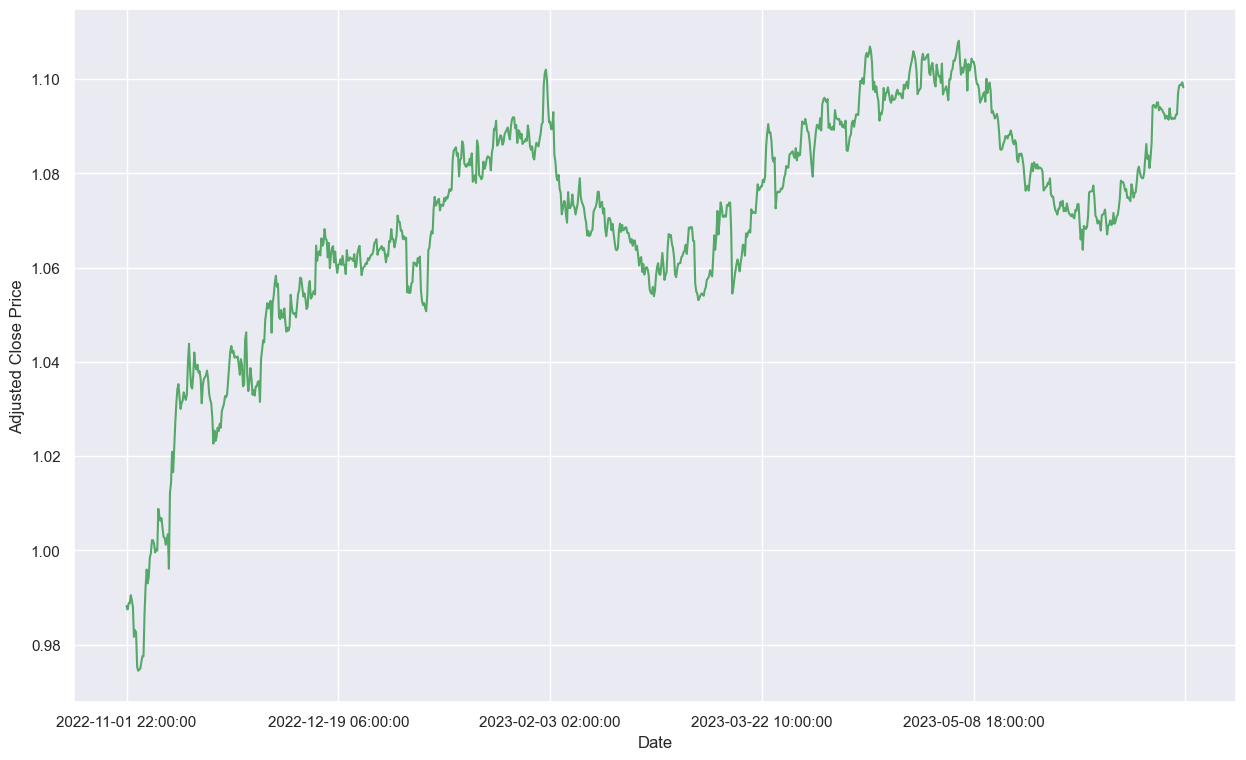

In [51]:
plt.figure(figsize = (15,9))
data['Adj Close'].plot(c = 'g')
plt.ylabel('Adjusted Close Price')
plt.show()

And here we plot the cumulative log returns $c_{t}$ and the total relative returns $c_{t}^{rel}$, given by:
$$
c_{t} = \sum_{k = 0}^{t} \ln(p_{k}/p_{k-1})\,,
$$
and
$$
c_{t}^{rel} = \exp(c_{t}) - 1
$$

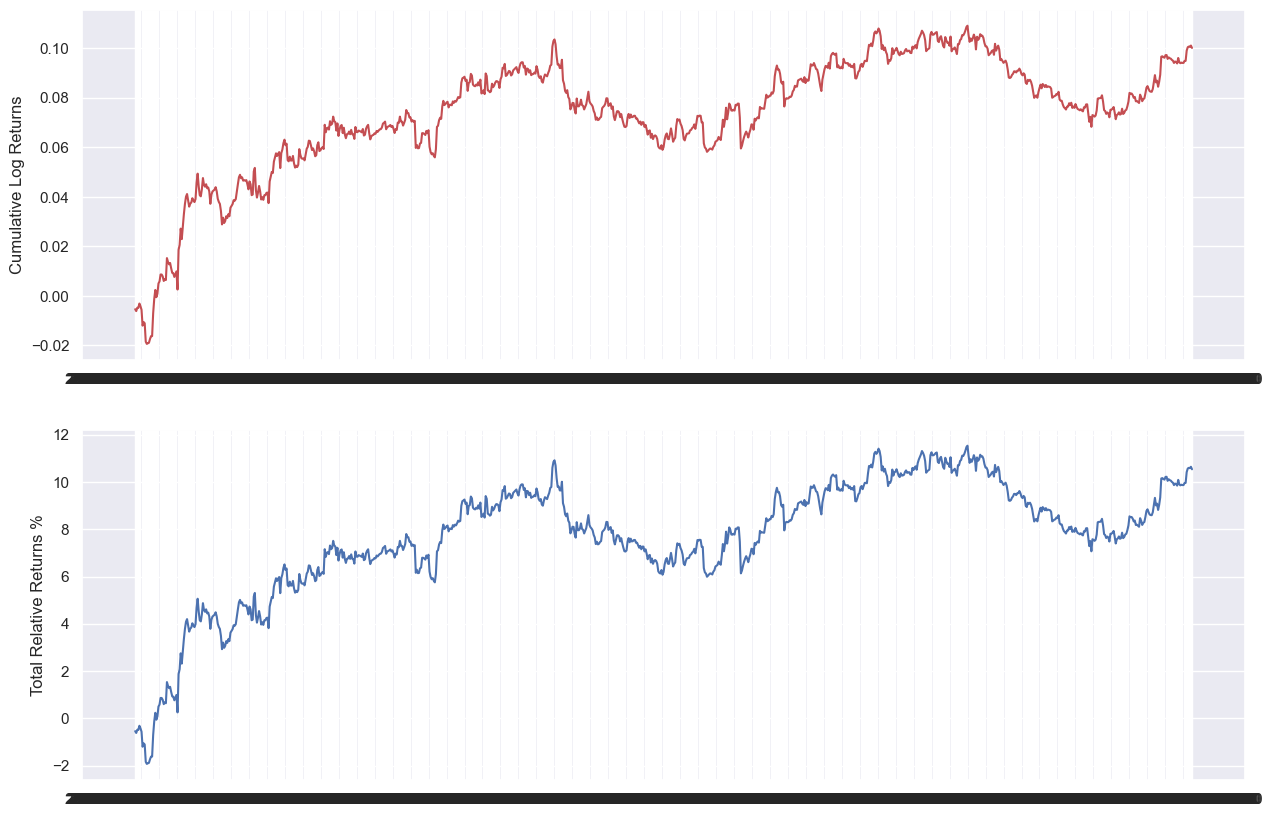

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))

ax1.plot(data['Log Returns'].cumsum(), c = 'r')
ax1.set_ylabel('Cumulative Log Returns')

ax2.plot(100*(np.exp(data['Log Returns'].cumsum())-1))
ax2.set_ylabel('Total Relative Returns %')

plt.show()

# ========================================================

We compute a fast moving average of 40 days (MA40) and a slow moving average of 252 days (MA252) on the Adj. Close Price. 

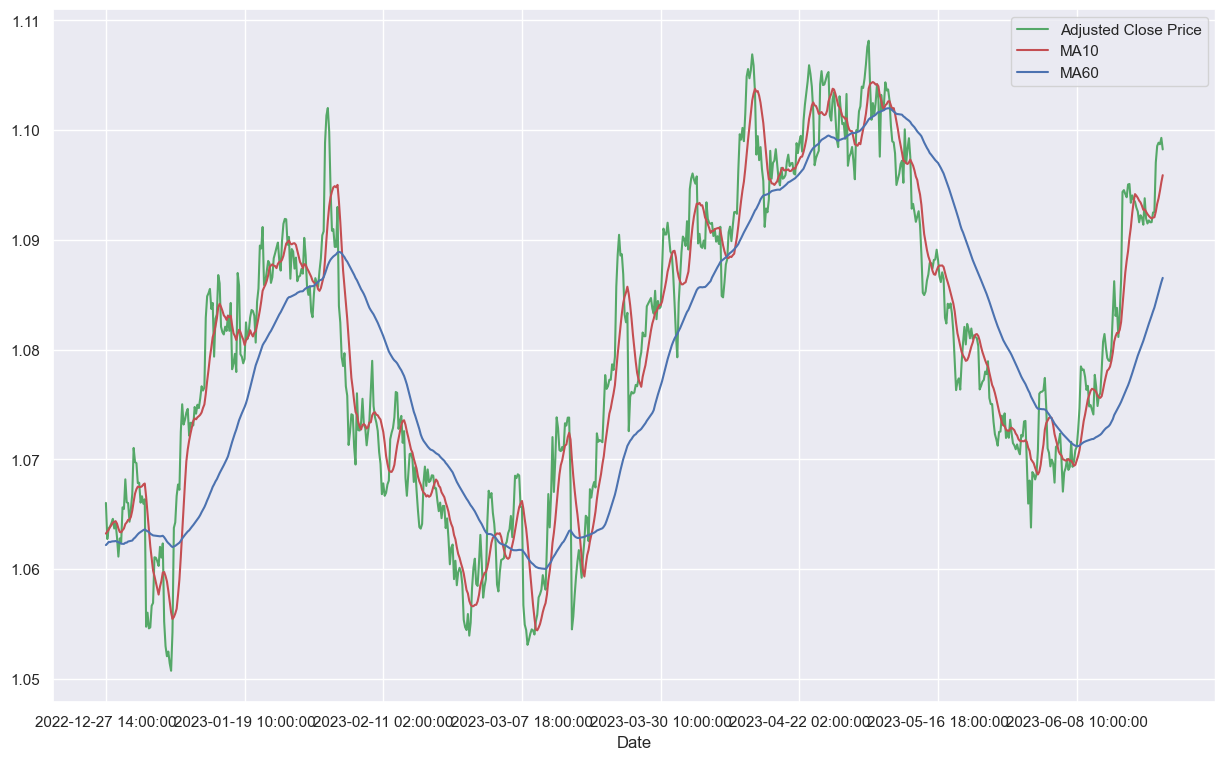

In [55]:
MAF = 10
MAS =60

data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
data.dropna(inplace=True)
# data.head()

# Thus, the Adj.Close price and both our moving averages look like this:

plt.figure(figsize= (15,9))
data['Adj Close'].plot(color = 'g', label = 'Adjusted Close Price')
data['MAFast'].plot(color = 'r', label = 'MA{}'.format(MAF) )
data['MASlow'].plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

# ===========================================================

We will now follow a simple strategy: if M45 > M252, we then long one share of stock; otherwise, we do nothing. Our signal is then defined as 

In [57]:
data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
data.dropna(inplace=True)
# data.head()

,Time,open,high,low,close,Date,Adj Close,Log Returns,MASlow,MAFast,Signal
Date,,,,,,,,,,,
2022-12-27 14:00:00,2022-12-27 14:00:00,1.06556,1.06676,1.06382,1.06604,2022-12-27 14:00:00,1.06604,0.000479,1.062201,1.063247,1
2022-12-27 18:00:00,2022-12-27 18:00:00,1.06607,1.06696,1.06192,1.06275,2022-12-27 18:00:00,1.06275,-0.003091,1.062329,1.063441,1
2022-12-27 22:00:00,2022-12-27 22:00:00,1.06275,1.06605,1.06116,1.06371,2022-12-27 22:00:00,1.06371,0.000903,1.062485,1.063611,1
2022-12-28 02:00:00,2022-12-28 02:00:00,1.06371,1.06564,1.06354,1.06390,2022-12-28 02:00:00,1.06390,0.000179,1.062473,1.063838,1
2022-12-28 06:00:00,2022-12-28 06:00:00,1.06389,1.06425,1.06243,1.06420,2022-12-28 06:00:00,1.06420,0.000282,1.062518,1.064036,1


In [58]:
# create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
data['Position'] = data['Signal'].diff()

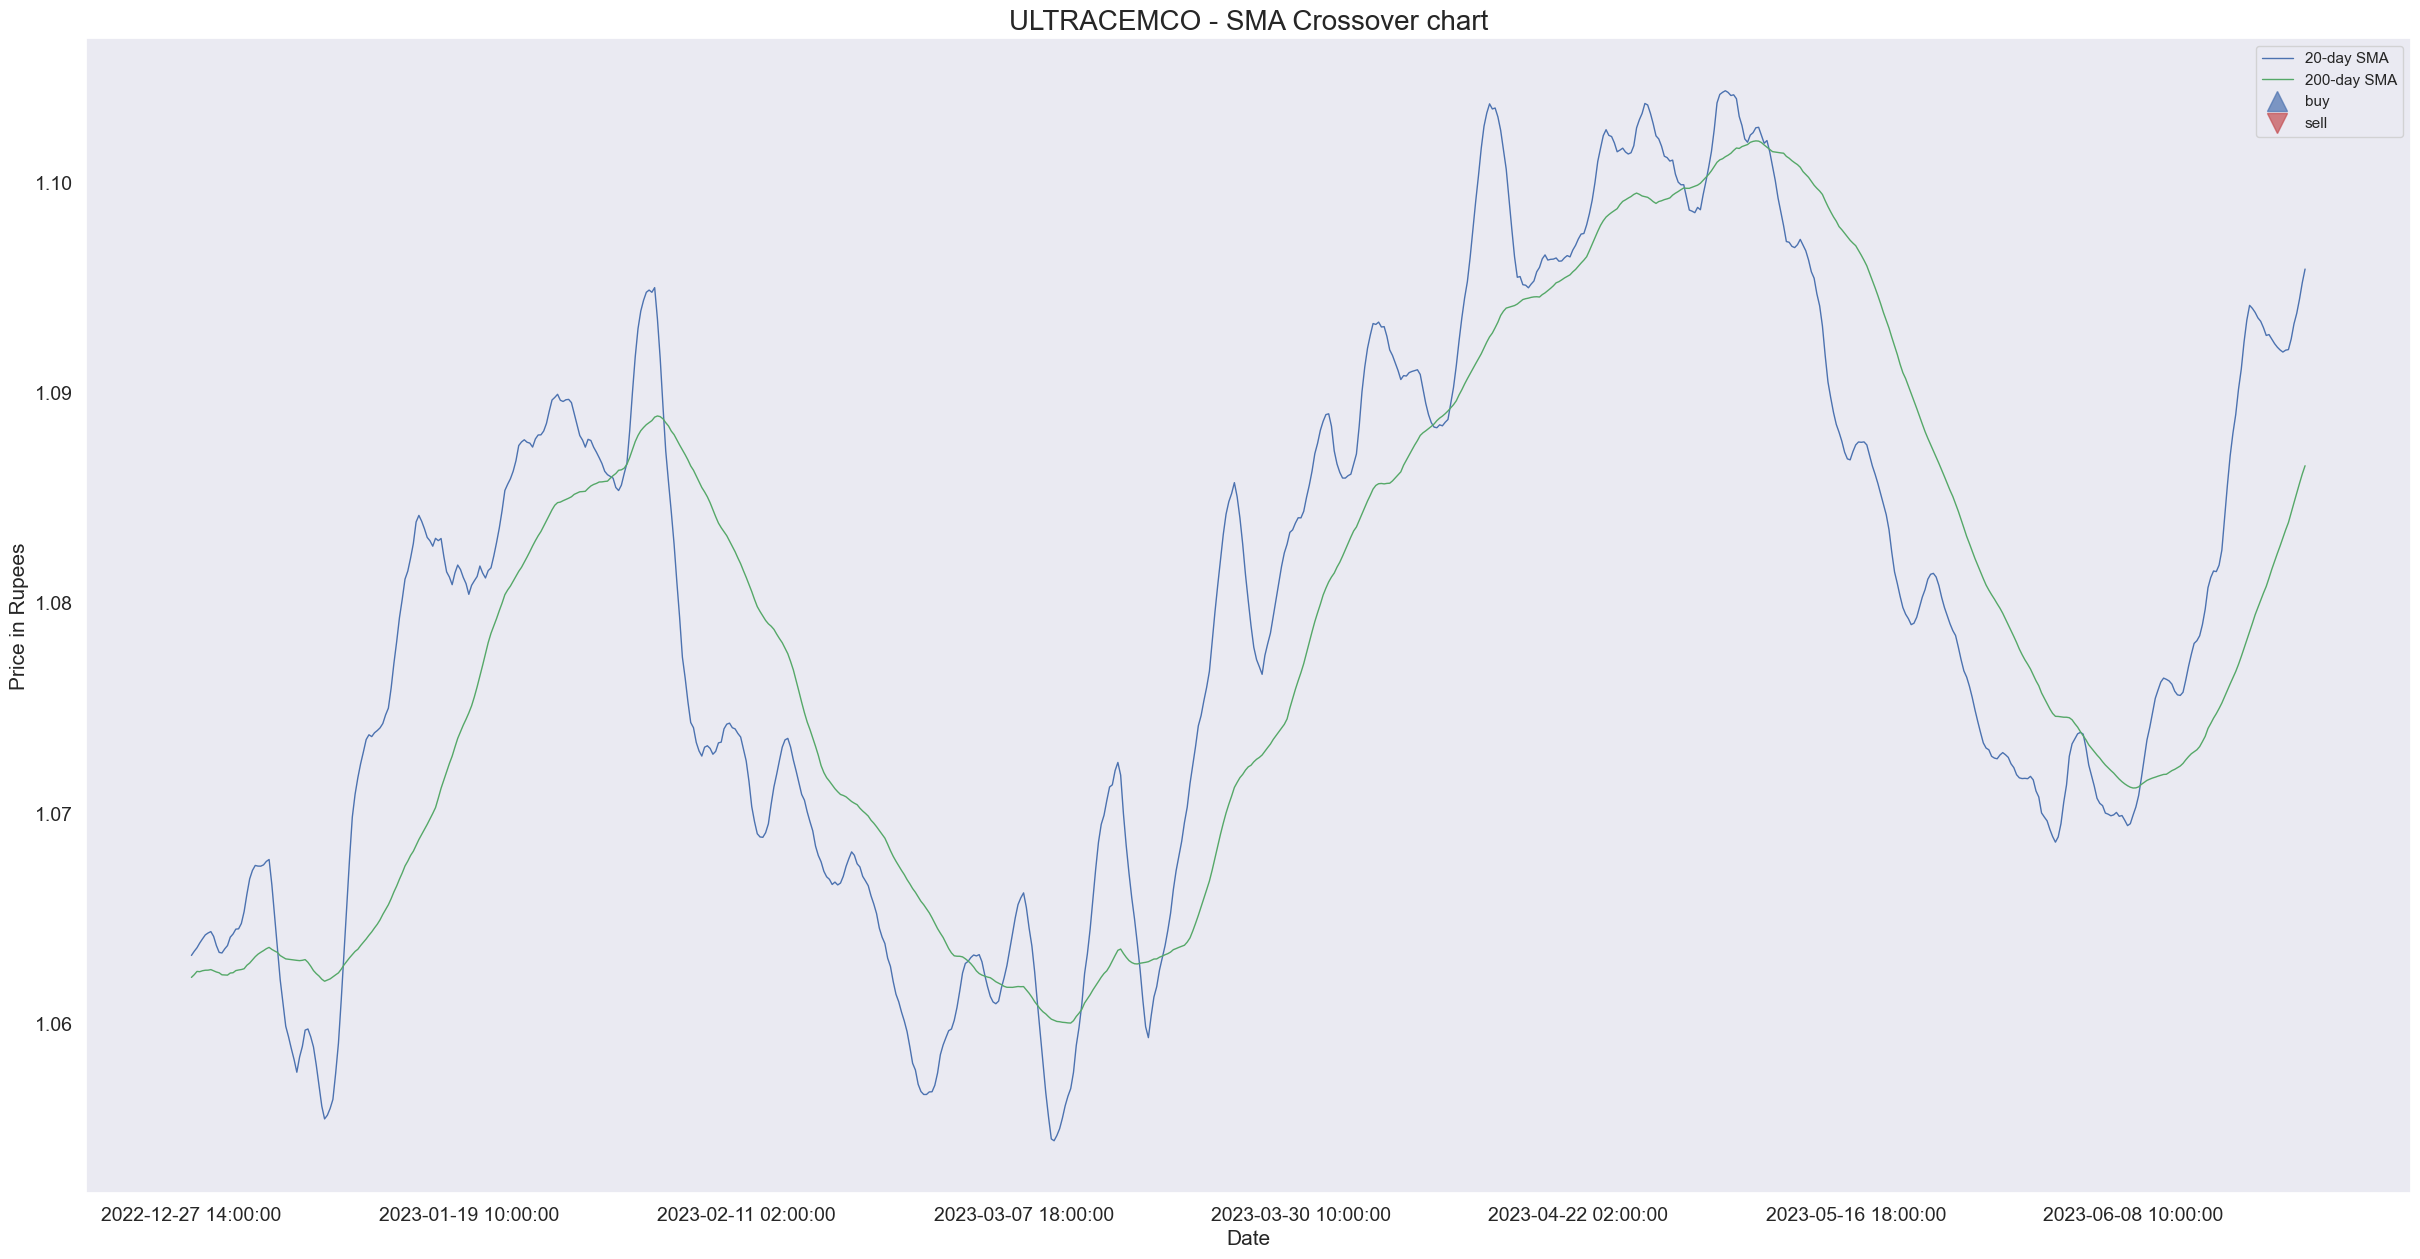

In [67]:
plt.figure(figsize = (30,15))
plt.tick_params(axis = 'both', labelsize = 14)
# plot close price, short-term and long-term moving averages 
# data['Adj Close'].plot(color = 'k', lw = 1, label = 'Close Price')  
data['MAFast'].plot(color = 'b', lw = 1, label = '20-day SMA') 
data['MASlow'].plot(color = 'g', lw = 1, label = '200-day SMA') 

# plot 'buy' signals
plt.plot(data[data['Position'] == 1].index, 
         data['MAFast'][data['Position'] == 1], 
         '^', markersize = 15, color = 'b', alpha = 0.7, label = 'buy')

# plot 'sell' signals
plt.plot(data[data['Position'] == -1].index, 
         data['MAFast'][data['Position'] == -1], 
         'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
plt.ylabel('Price in Rupees', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('ULTRACEMCO - SMA Crossover chart', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

We see that, I we were to follow this strategy, we would go long more often than short:

Signal
 1    393
-1    281
Name: count, dtype: int64


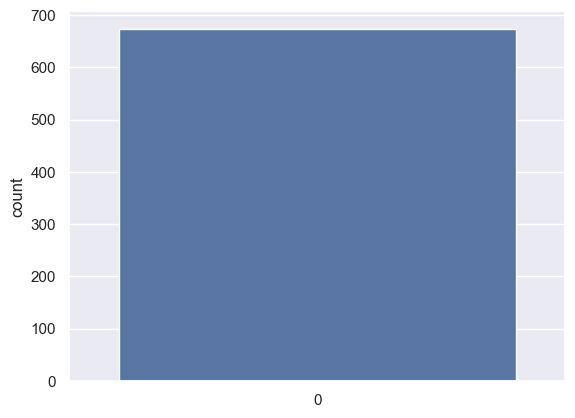

In [36]:
sns.countplot(data['Signal'])
print(data['Signal'].value_counts())

And here plot the adjusted close price for our stock, the slow/fast moving averages and the short/long signal:

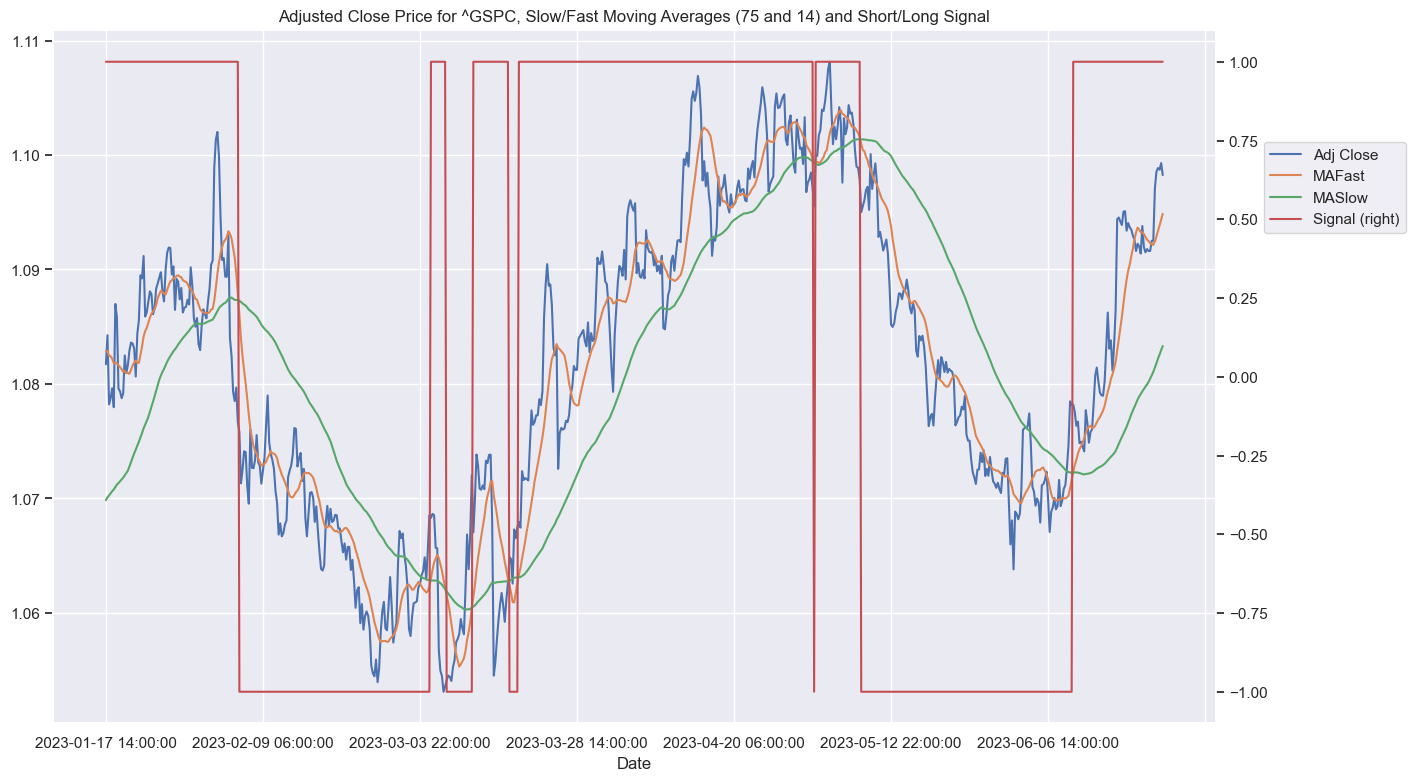

In [37]:
Ax = data[['Adj Close','MAFast','MASlow','Signal']].plot(secondary_y='Signal',figsize=(15,9),title='Adjusted Close Price for {}, Slow/Fast Moving Averages ({} and {}) and Short/Long Signal'.format(stock[0],MAS,MAF))
#Ax.title('Hello')
Ax.get_legend().set_bbox_to_anchor((1.17, 0.85))

# ========================================================

Following this strategy, the daily returns $R_{t}^{S}$ would be given by the product of the log return $R_{t}$ times our signal $O_{t}$, like so:
$$
R^{S}_{t} = O_{t} R_{t}
$$

In [38]:
data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
data.dropna(inplace=True)

(We note that we have shifted the signal for one day, since we implement the strategy on the day after the closing.)

The results of the strategy are not encouraging. We compare it to a 'Buy and Hold' strategy:

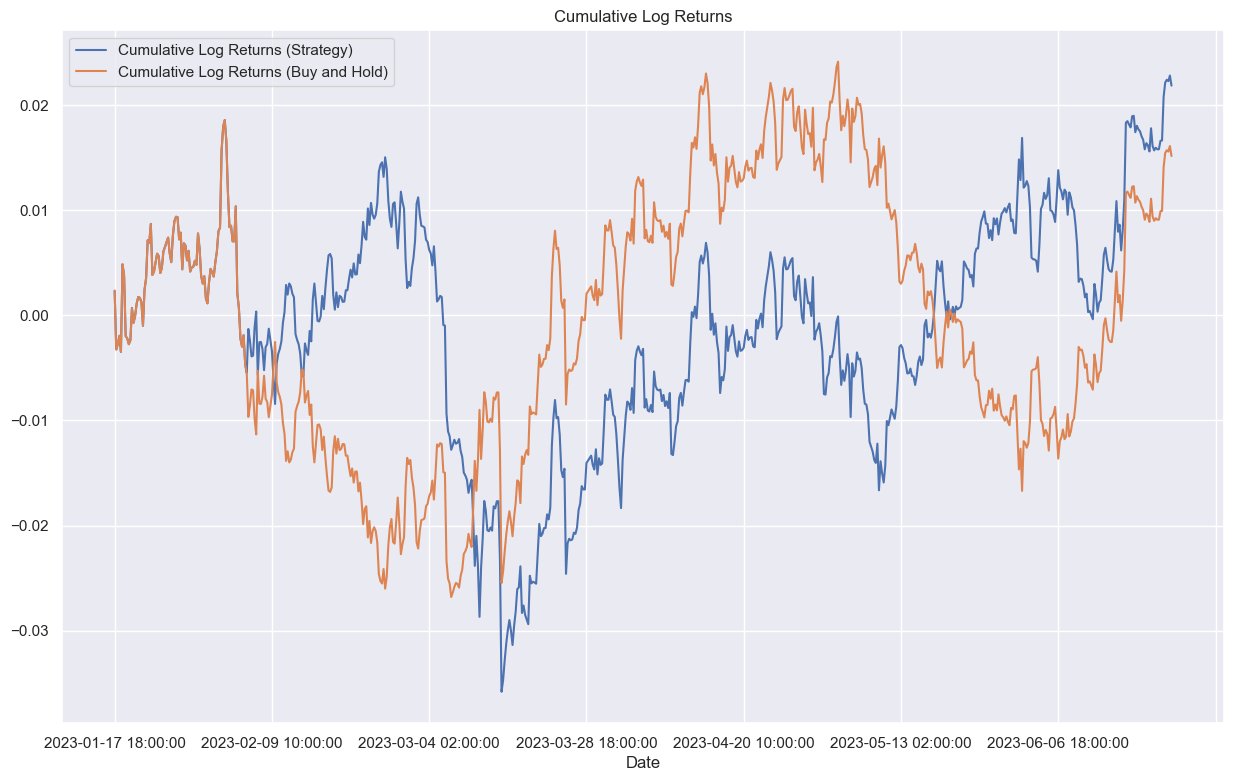

In [39]:
plt.figure(figsize = (15,9))
data['Strategy Log Returns'].cumsum().plot(label = 'Cumulative Log Returns (Strategy)')
data['Log Returns'].cumsum().plot(label = 'Cumulative Log Returns (Buy and Hold)')
plt.title('Cumulative Log Returns')
plt.legend()
plt.show()

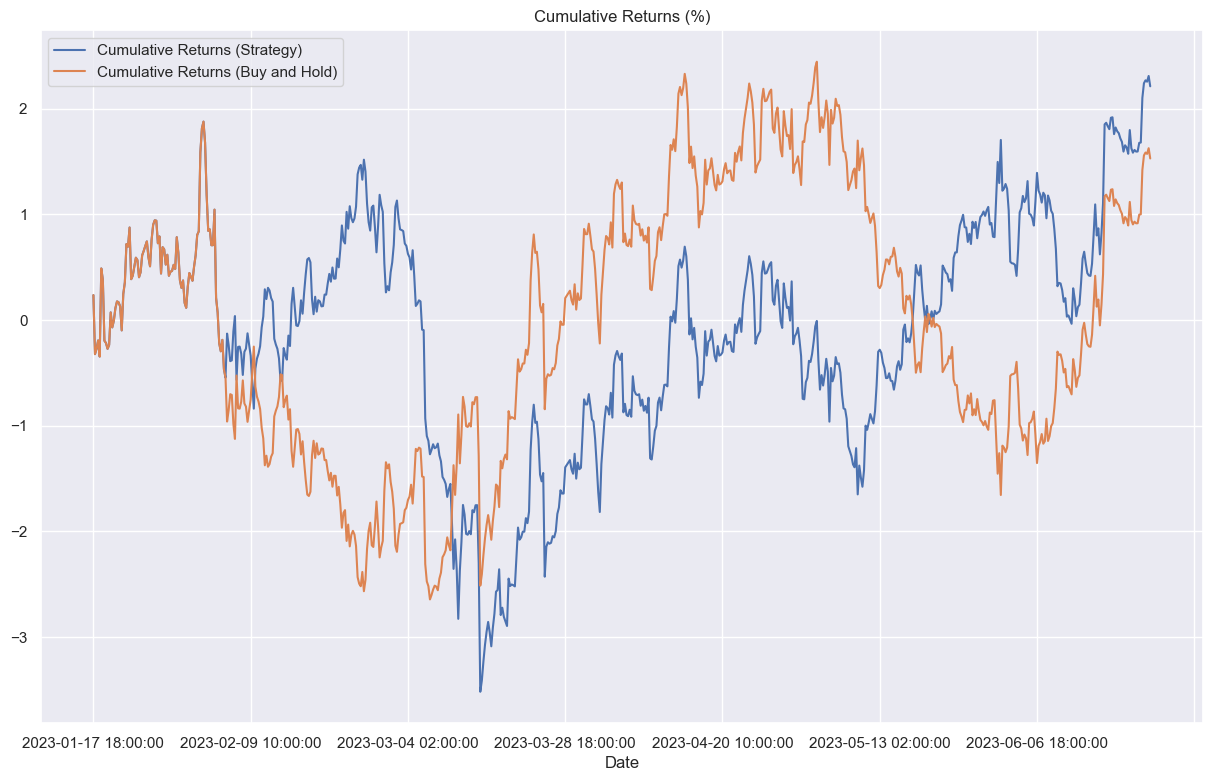

In [40]:
#print('Total Buy and Hold return (%) is : ', 100*(np.exp(data['Log Returns'].sum())-1).round(4),'%')
#print('Total strategy return (%) is : ', 100*(np.exp(data['Strategy Log Returns'].sum())-1).round(4),'%')

plt.figure(figsize = (15,9))
(100*(np.exp(data['Strategy Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Strategy)')
(100*(np.exp(data['Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Buy and Hold)')
plt.title('Cumulative Returns (%)')
plt.legend()
plt.show()

So, for this share the strategy underperforms and it is better to stick to Buy and Hold.

To evaluate the strategy better, we compute the total returns for the strategy and the market cases, as well as the annualized volatility:

In [41]:
print('Total Returns')
print(25*'===')
print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')

Total Returns
Market Total Return: 1.528 %
Strategy Total Return: 2.211 %


In [42]:
print('Annualized Volatility')
print(25*'===')
print('Market Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[0],'%')
print('Strategy Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[1],'%')

Annualized Volatility
Market Volatility: 0.03228 %
Strategy Volatility: 0.03228 %


# ===========================================================

Now, we make a general script. Given the stock, the start and ending dates and our fast and slow moving averages, we will obtain: a) a plot showing the adj. close price, the MAs and the strategy signal, b) a plot comparing the market and strategy relative cumulative returns, and c) information about the market and strategy total returns and annualized volatility.

In [43]:
def MA_Strategy(stock,start,end,MAF,MAS):
    data = pdr.get_data_yahoo(stock, start=start, end=end)
    data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data.dropna(inplace=True)
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # We show the results:
    
    data[['Adj Close','MAFast','MASlow','Signal']].plot(secondary_y='Signal',figsize=(15,9),title='Adjusted Close Price for {}, Slow/Fast Moving Averages ({} and {}) and Short/Long Signal'.format(stock[0],MAS,MAF)).get_legend().set_bbox_to_anchor((1.17, 0.85))

    plt.figure(figsize = (15,9))
    (100*(np.exp(data['Strategy Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Strategy)')
    (100*(np.exp(data['Log Returns'].cumsum())-1)).plot(label = 'Cumulative Returns (Buy and Hold)')
    plt.title('Cumulative Returns (%): {}'.format(stock[0]))
    plt.legend()
    plt.show()
    
    print('\n')
    print('Total Returns:', stock[0])
    print(35*'===')
    print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
    print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')
    print('\n')
    print('Annualized Volatility:', stock[0])
    print(35*'===')
    print('Market Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[0],'%')
    print('Strategy Volatility:',(data[['Log Returns', 'Strategy Log Returns']].std()*252**0.5).round(5).iloc[1],'%')

We try with the S&P 500 index again, just to check:

[*********************100%***********************]  1 of 1 downloaded


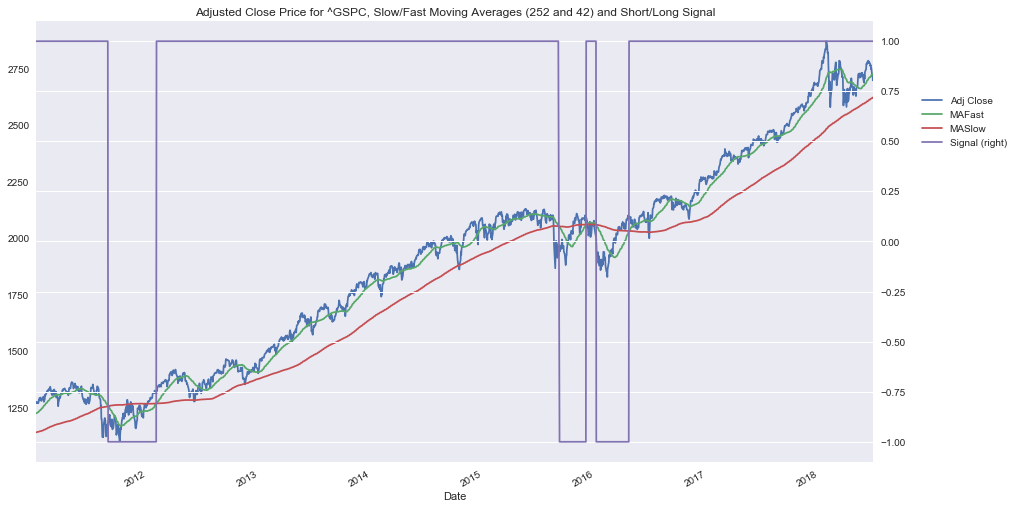

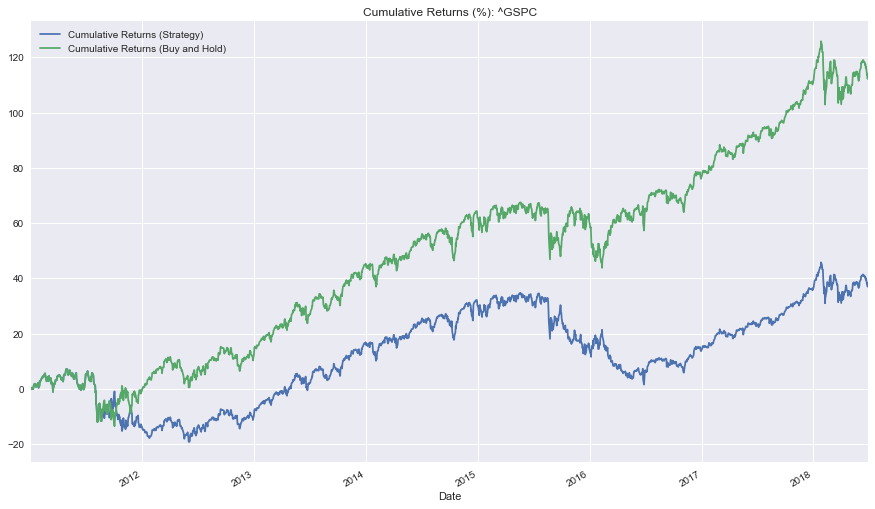



Total Returns: ^GSPC
Market Total Return: 113.73 %
Strategy Total Return: 37.937 %


Annualized Volatility: ^GSPC
Market Volatility: 0.14379 %
Strategy Volatility: 0.1439 %


In [12]:
stock =['^GSPC']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

We now try Apple stocks. We observe that the strategy performs better than the market:

[*********************100%***********************]  1 of 1 downloaded


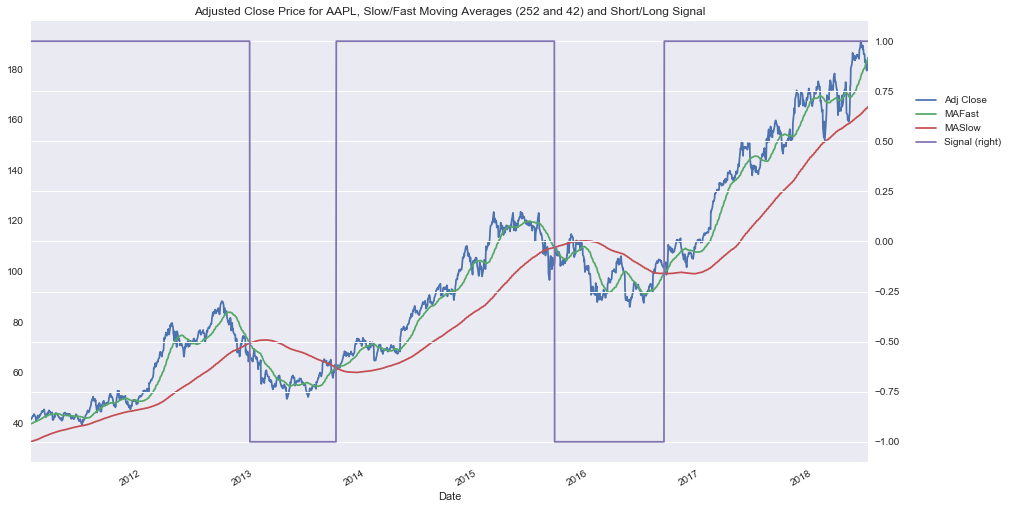

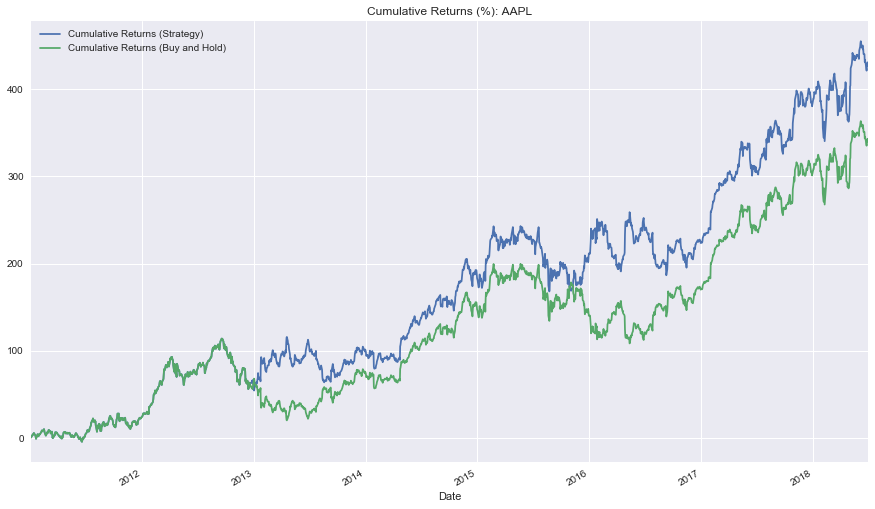



Total Returns: AAPL
Market Total Return: 342.119 %
Strategy Total Return: 429.533 %


Annualized Volatility: AAPL
Market Volatility: 0.25033 %
Strategy Volatility: 0.25025 %


In [18]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

And finally, GE. The strategy again gives us better-than-market returns:

[*********************100%***********************]  1 of 1 downloaded


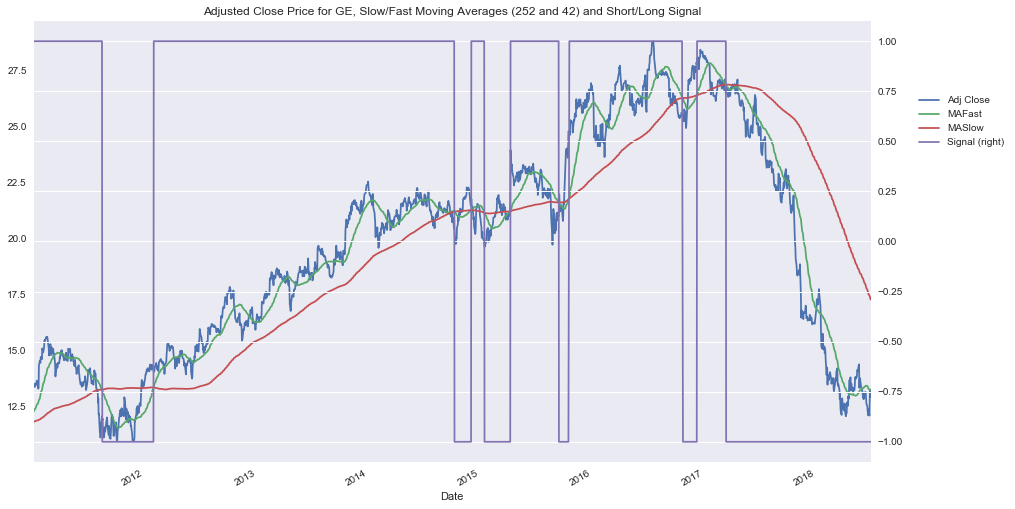

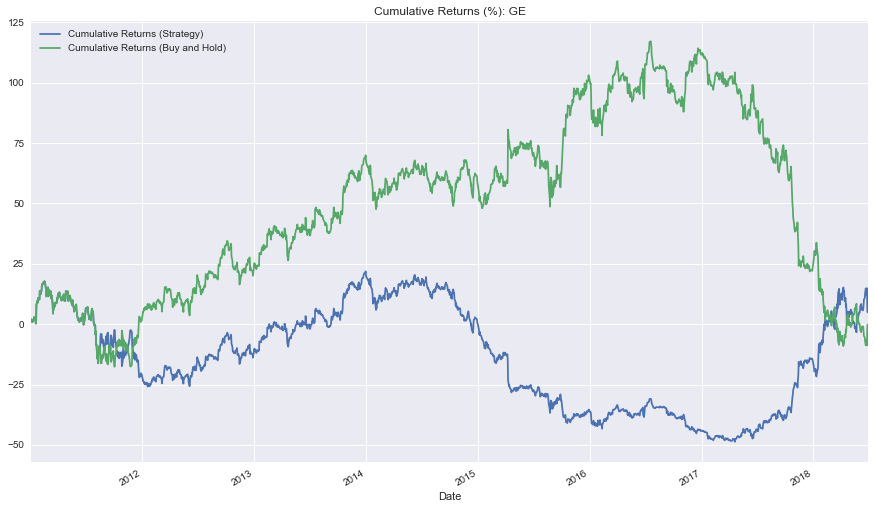



Total Returns: GE
Market Total Return: -2.638 %
Strategy Total Return: 7.62 %


Annualized Volatility: GE
Market Volatility: 0.21921 %
Strategy Volatility: 0.21921 %


In [19]:
stock =['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 42
MAS =252

MA_Strategy(stock,start,end,MAF,MAS)

We can make a shorter script that gives us only the total returns, for convenience

In [10]:
def MA_Strategy_Short(stock,start,end,MAF,MAS):
    data = pdr.get_data_yahoo(stock, start=start, end=end)
    data['Log Returns'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MAS).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAF).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data.dropna(inplace=True)
    data['Strategy Log Returns'] = data['Log Returns'] * data['Signal'].shift(1)
    data.dropna(inplace=True)
    
    # We show the results:
    
    print('\n')
    print('Total Returns:', stock[0])
    print(35*'===')
    print('Market Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[0],'%')
    print('Strategy Total Return:',((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).round(3).iloc[1],'%')
    

In [72]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
MAF = 20
MAS =180

MA_Strategy_Short(stock,start,end,MAF,MAS)

[*********************100%***********************]  1 of 1 downloaded


Total Returns: AAPL
Market Total Return: 413.461 %
Strategy Total Return: 299.048 %


# ========================================================

Finally, we can try to optimize the strategy return by choosing different periods for the moving averages. In this case, we will focus on Apple stocks. We will consider a Fast MA interval of (10, 90) and a Slow MA interval of (100, 250). We use the itertools library, which we have allready called at the beggining of the script.

In [6]:
stock = ['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_apple = pdr.get_data_yahoo(stock, start=start, end=end) 
data_apple.to_csv('apple.cvs') 
pd.read_csv('apple.cvs').head(3)

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.49,30.64,30.34,30.57,26.78,123432400
1,2010-01-05,30.66,30.80,30.46,30.63,26.83,150476200
2,2010-01-06,30.63,30.75,30.11,30.14,26.40,138040000


In [7]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 
stock = ['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

show = pd.DataFrame()
for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('apple.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)  

This gives us the following slow/fast moving average strategies, sorted in descending order from the one with the highest strategy return relative to the market return:

In [8]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
233,180,85,413.461,680.189,266.728
97,170,40,465.189,670.402,205.212
219,190,80,404.231,589.336,185.105
29,240,15,354.802,538.136,183.335
147,220,55,383.121,559.985,176.864


We inspect the top strategy in more detail:

[*********************100%***********************]  1 of 1 downloaded


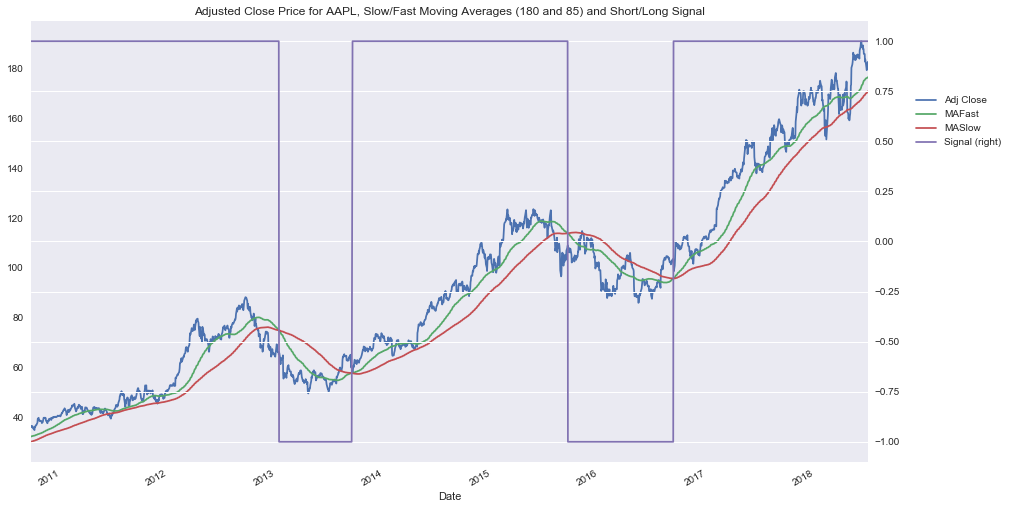

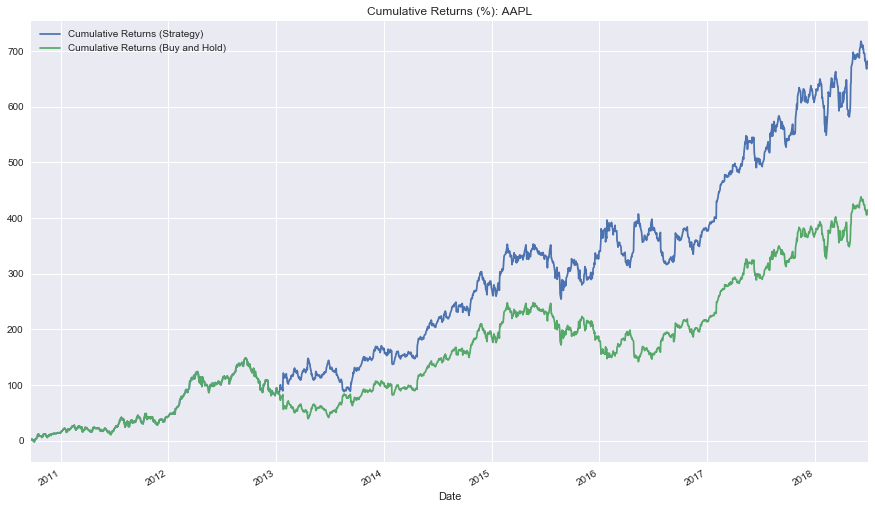



Total Returns: AAPL
Market Total Return: 413.461 %
Strategy Total Return: 680.189 %


Annualized Volatility: AAPL
Market Volatility: 0.24849 %
Strategy Volatility: 0.24829 %


In [13]:
stock =['AAPL']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

MAS = 180
MAF = 85

MA_Strategy(stock,start,end,MAF,MAS)

Let us now see if we can choose any MA strategy  for GSPC that can gives us above-than-market returns:

In [14]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 

stock = ['^GSPC']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_GSPC = pdr.get_data_yahoo(stock, start=start, end=end) 
data_GSPC.to_csv('GSPC.cvs') 

show = pd.DataFrame()

for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('GSPC.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)  

[*********************100%***********************]  1 of 1 downloaded


In [15]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
59,240,25,120.070,72.228,-47.842
179,240,65,120.070,64.536,-55.534
194,240,70,120.070,64.291,-55.779
193,230,70,125.391,68.586,-56.805
58,230,25,125.391,67.247,-58.143


So, apparently there are no wining MA strategies for GSPC in our set.

Finally, we do the same for GE and find a better MA strategy:

In [16]:
sma1 = range(10, 90, 5)  
sma2 = range(100, 250, 10) 

stock = ['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')
data_GE = pdr.get_data_yahoo(stock, start=start, end=end) 
data_GE.to_csv('GE.cvs') 

show = pd.DataFrame()

for MAFast, MASlow in product(sma1, sma2): 
    
    data = pd.read_csv('GE.cvs')
    data.dropna(inplace=True)
    data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data.dropna(inplace=True)
    data['MASlow'] = data['Adj Close'].rolling(MASlow).mean()
    data['MAFast'] = data['Adj Close'].rolling(MAFast).mean()
    data.dropna(inplace=True)
    data['Signal'] = np.where(data['MAFast']>data['MASlow'],1,-1)
    data['Strategy Log Returns'] = data['Log Returns'] * (data['Signal'].shift(1))
    data.dropna(inplace=True)
    
    ret = (np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100
    
    show = show.append(pd.DataFrame(
                         {'MA Slow': MASlow, 'MA Fast': MAFast,
                          'Market Return (%)':  ((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[0].round(3),
                          'Strategy Return (%)':((np.exp(data[['Log Returns', 'Strategy Log Returns']].sum()) -1)*100).iloc[1].round(3),
                          'Difference in Returns (%)': (ret['Strategy Log Returns'] - ret['Log Returns']).round(3)},
                          index=[0]), ignore_index=True)  

[*********************100%***********************]  1 of 1 downloaded


In [17]:
show.sort_values('Difference in Returns (%)', ascending= False).head(5)

,MA Slow,MA Fast,Market Return (%),Strategy Return (%),Difference in Returns (%)
229,140,85,11.958,178.817,166.858
34,140,20,11.958,171.498,159.540
95,150,40,10.333,166.469,156.136
35,150,20,10.333,155.500,145.167
228,130,85,21.087,152.732,131.645


[*********************100%***********************]  1 of 1 downloaded


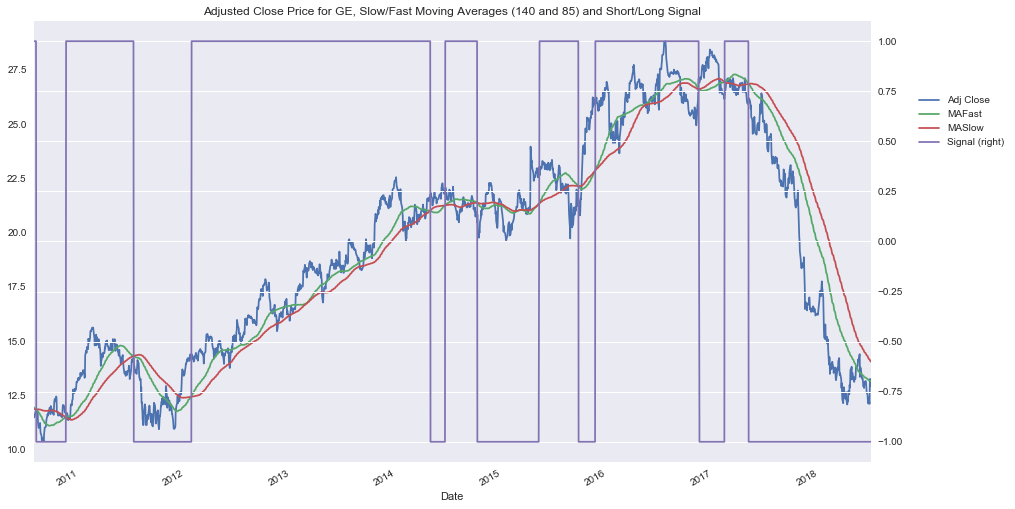

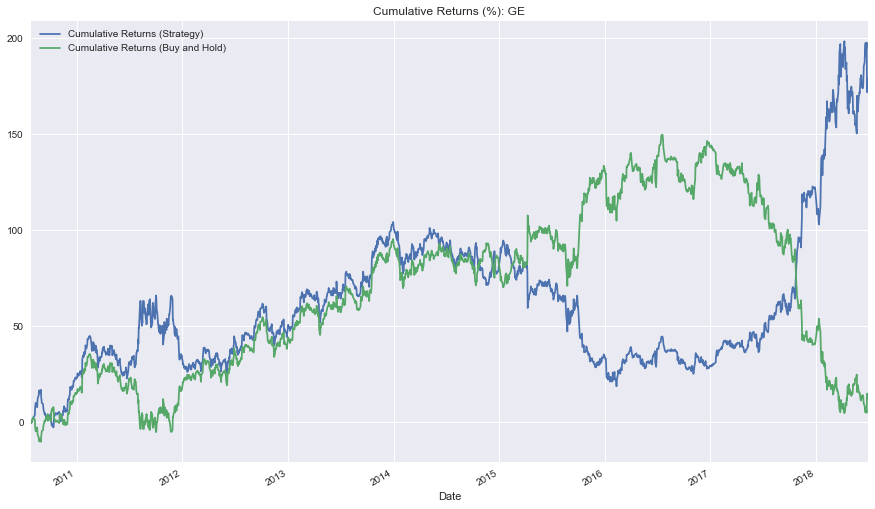



Total Returns: GE
Market Total Return: 11.958 %
Strategy Total Return: 178.817 %


Annualized Volatility: GE
Market Volatility: 0.21896 %
Strategy Volatility: 0.21881 %


In [18]:
stock =['GE']
start = pd.to_datetime('2010-01-01') 
end = pd.to_datetime('2018-06-29')

MAS = 140
MAF = 85

MA_Strategy(stock,start,end,MAF,MAS)